# Section 4.2.6. Score-Based Generative Model (Noise Conditional Score Network)

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary

from utils import *

torch.manual_seed(0)

In [2]:
# -------------------------------
# Define the Score Model
# -------------------------------
# Building blocks for the model
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, n_steps):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features)
        self.embed = nn.Embedding(n_steps, num_features * 2)
        self.embed.weight.data[:, :num_features].uniform_()
        self.embed.weight.data[:, num_features:].zero_()

    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, dim=1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_steps, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation)
        self.norm1 = ConditionalBatchNorm2d(out_channels, n_steps)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation)
        self.norm2 = ConditionalBatchNorm2d(out_channels, n_steps)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1) if in_channels != out_channels else nn.Identity()
        self.act = nn.ELU()

    def forward(self, x, y):
        out = self.act(self.norm1(self.conv1(x), y))
        out = self.norm2(self.conv2(out), y)
        out += self.shortcut(x)
        return self.act(out)

class CondRefineNetDilated(nn.Module):
    def __init__(self, n_steps, input_dim):
        super().__init__()
        self.n_steps = n_steps
        self.input_dim = input_dim
        self.num_filter = 128

        self.begin_conv = nn.Conv2d(self.input_dim, self.num_filter, kernel_size=3, padding=1)
        self.end_conv = nn.Conv2d(self.num_filter * 2, self.input_dim, kernel_size=3, padding=1)
        self.act = nn.ELU()

        self.res1 = ResidualBlock(self.num_filter, self.num_filter, n_steps)
        self.res2 = ResidualBlock(self.num_filter, 2 * self.num_filter, n_steps, dilation=2)
        self.res3 = ResidualBlock(2 * self.num_filter, 2 * self.num_filter, n_steps, dilation=4)
        self.res4 = ResidualBlock(2 * self.num_filter, 2 * self.num_filter, n_steps, dilation=8)

    def forward(self, x, y):
        out = self.act(self.begin_conv(x))
        out = self.res1(out, y)
        out = self.res2(out, y)
        out = self.res3(out, y)
        out = self.res4(out, y)
        out = self.act(out)
        out = self.end_conv(out)
        return out

# Score model
class Model(nn.Module):
    def __init__(self, n_steps, sigma_min, sigma_max, input_dim):
        super().__init__()
        # sigmas: small values mean less noise, large values mean more noise (exponential scale)
        self.sigmas = np.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps=n_steps))
        self.conv_layer = CondRefineNetDilated(n_steps, input_dim)

    def loss_fn(self, x, idx=None):
        scores, target, sigma = self.forward(x, idx=idx, get_target=True)
        target = target.view(target.shape[0], -1)
        scores = scores.view(scores.shape[0], -1)
        losses = torch.square(scores - target).mean(dim=-1) * sigma.squeeze() ** 2
        return losses.mean(dim=0)

    def forward(self, x, idx=None, get_target=False):
        if idx is None:
            idx = torch.randint(0, len(self.sigmas), (x.size(0), 1))
            used_sigmas = self.sigmas[idx][:, :, None, None].to(x.device)
            noise = torch.randn_like(x)
            x_tilde = x + noise * used_sigmas
            idx = idx.squeeze()
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).long()
            x_tilde = x
        if get_target:
            target = -1 / (used_sigmas) * noise
        output = self.conv_layer(x_tilde, idx.to(x.device))
        return (output, target, used_sigmas) if get_target else output

![alt text](img/Score_based_Generative_Model_edit.png "Title")

The objective function of Score-based Model can be defined as

- $\mathbb{E}_{\mathbf{x} \sim p(\mathbf{x})} \left[\mathbb{E}_{\tilde{\mathbf{x}} \sim q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right)} \left|\left|{ \nabla_{\mathbf{x}} \log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) - s_{\theta} (\tilde{\mathbf{x}} , \sigma)}^2 \right|\right| _2 \right] $

<br/>
<br/>

We are using the normal distribution for the noise. Therefore

- $q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left(-\frac{\left(\tilde{\mathbf{x}}-\mathbf{x} \right)^2}{2 \sigma^2}\right)$

- $\log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) = -\frac{\left(\tilde{\mathbf{x}}-\mathbf{x}\right)^2}{2 \sigma^2}-\log \left(\sqrt{2 \pi \sigma^2}\right)$

- $\nabla_{\mathbf{x}} \log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) = -\frac{\left(\tilde{\mathbf{x}}-\mathbf{x}\right)}{\sigma^2}$

<br/>
<br/>

By definition, $\tilde{\mathbf{x}}$ is defined as $\tilde{\mathbf{x}}=\mathbf{x}+\sigma \cdot \epsilon$. Then $\nabla_{\mathbf{x}} \log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right)$ is transformed as

- $ \begin{align} \nabla_{\mathbf{x}} \log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) &= -\frac{\left(\tilde{\mathbf{x}}-\mathbf{x}\right)}{\sigma^2} \\ &= -\frac{\left(\mathbf{x}+\sigma \cdot \epsilon-\mathbf{x}\right)}{\sigma^2}\\ &= -\frac{\epsilon}{\sigma}\\ \end{align} $

<br/>
<br/>

Practically, $\sigma^2$ is multiplied to the objective function as the weight.

## 1. Training Stage

In [3]:
# -------------------------------
# Training
# -------------------------------
def train_score_model(model, data_loader, optimizer, num_epochs, device):
    model.train()
    total_samples = len(data_loader.dataset)
    for epoch in range(num_epochs):
        train_loss = 0.0
        for data in data_loader:
            optimizer.zero_grad()
            data = data.to(device)
            batch_size = data.size(0)
            loss = model.loss_fn(data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_size
        avg_loss = train_loss / total_samples
        print(f"Epoch [{epoch+1:02}/{num_epochs}] Loss: {avg_loss:>6.4f}")
    return model

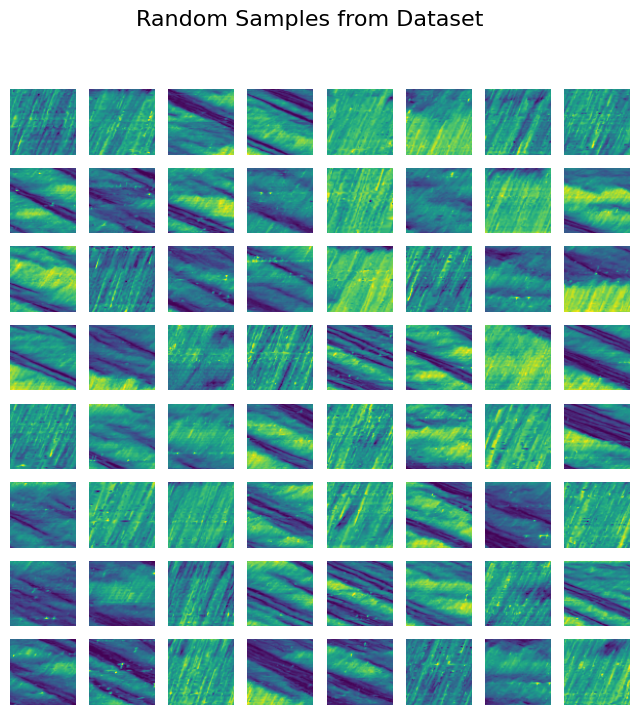

In [4]:
data_path = '../dataset/i24_normalized.pt' 
batch_size = 250 
num_epochs = 18
n_steps = 25          # number of steps for the noise level
sigma_min = 0.05
sigma_max = 1.5
eps = 1e-4

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

dataset, data_loader = load_and_preprocess_data(data_path, batch_size)

input_dim = dataset.shape[1]  # data shape: [40000, 1, 64, 64] → input_dim = 1

score_fn = Model(n_steps, sigma_min, sigma_max, input_dim).to(device)
optimizer = torch.optim.Adam(score_fn.parameters(), lr=0.0015)

In [5]:
score_fn = train_score_model(score_fn, data_loader, optimizer, num_epochs, device)

os.makedirs("models", exist_ok=True)
torch.save(score_fn.state_dict(), 'models/score_fn.pth')
print("Score Network model saved.")

Epoch [01/18] Loss: 0.6749
Epoch [02/18] Loss: 0.1628
Epoch [03/18] Loss: 0.0729
Epoch [04/18] Loss: 0.0636
Epoch [05/18] Loss: 0.0594
Epoch [06/18] Loss: 0.0564
Epoch [07/18] Loss: 0.0563
Epoch [08/18] Loss: 0.0546
Epoch [09/18] Loss: 0.0539
Epoch [10/18] Loss: 0.0535
Epoch [11/18] Loss: 0.0533
Epoch [12/18] Loss: 0.0523
Epoch [13/18] Loss: 0.0516
Epoch [14/18] Loss: 0.0517
Epoch [15/18] Loss: 0.0513
Epoch [16/18] Loss: 0.0507
Epoch [17/18] Loss: 0.0505
Epoch [18/18] Loss: 0.0511
Score Network model saved.


## 2. Testing Stage

In [6]:
# -------------------------------
# Annealed Langevin Dynamics and Sampling
# -------------------------------
class AnnealedLangevinDynamic():
    def __init__(self, sigma_min, sigma_max, n_steps, annealed_step, score_fn, device, eps=1e-1, input_dim=1):
        # process: sigma value (exponential scale) to use at each step
        self.process = np.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps=n_steps))
        # step size for each step 
        self.step_size = eps * (self.process / self.process[-1]) ** 2
        self.score_fn = score_fn
        self.annealed_step = annealed_step
        self.input_dim = input_dim

    def _one_annealed_step_iteration(self, x, idx):
        self.score_fn.eval()
        z = torch.randn_like(x)
        step_size = self.step_size[idx]
        x = x + 0.5 * step_size * self.score_fn(x, idx) + torch.sqrt(step_size) * z
        return x

    def _one_annealed_step(self, x, idx):
        for _ in range(self.annealed_step):
            x = self._one_annealed_step_iteration(x, idx)
        return x

    def _one_diffusion_step(self, x):
        for idx in range(len(self.process)):
            x = self._one_annealed_step(x, idx)
            yield x

    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        sample = torch.rand([sampling_number, self.input_dim, 64, 64]).to(next(self.score_fn.parameters()).device)
        sampling_list = []
        final = None
        for sample in self._one_diffusion_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)
        return final if only_final else torch.stack(sampling_list)

The sample is generated by Annealed Langevin Dynamics.

- $\mathbf{x}_{i+1} \leftarrow \mathbf{x}_{i} +  s_{\theta} (\mathbf{x}_i) \cdot \epsilon + \sqrt{2\epsilon} \cdot \mathbf{z}_i$

In [7]:
def visualize_score_samples(dynamic, sampling_number, save_path="img/NCSN_result.png"):
    dynamic.score_fn.eval()
    sample = dynamic.sampling(sampling_number, only_final=True)
    sample_np = sample.cpu().numpy()
    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            idx = i * 8 + j
            ax[i, j].imshow(sample_np[idx][0, :, :], origin="lower", cmap="viridis")
            ax[i, j].axis("off")
    plt.savefig(save_path, dpi=500)
    plt.show()
    plt.close()

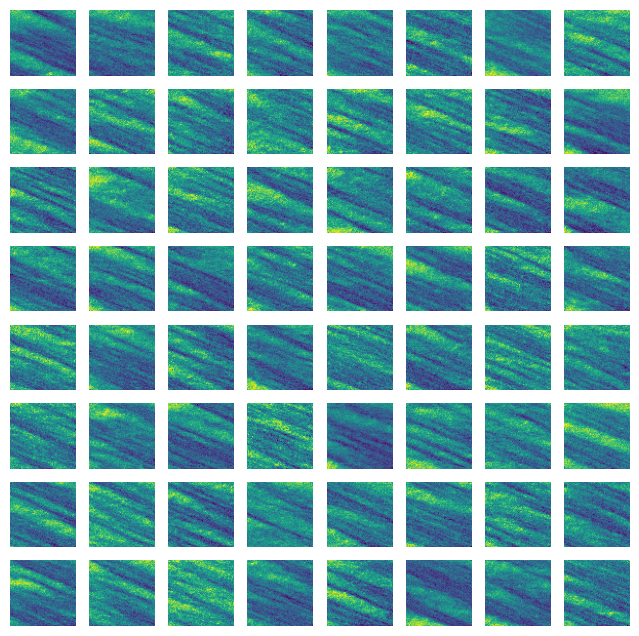

In [8]:
# Can use CPU in the inference, but highly recommended to use GPU
# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

score_fn = Model(n_steps, sigma_min, sigma_max, input_dim).to(device)
score_fn.load_state_dict(torch.load('models/score_fn.pth', map_location=device))
score_fn.eval()

# Annealed Langevin Dynamics and Sampling
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step=200, score_fn=score_fn, device=device, eps=eps, input_dim=input_dim)

os.makedirs("img", exist_ok=True)
visualize_score_samples(dynamic, sampling_number=64, save_path="img/NCSN_result.png")